The RDKit's code for doing R-group decomposition is quite flexible but also rather "undocumented". Thanks to that fact, you may not be aware of some of the cool stuff that's there. This post is an attempt to at least begin to remedy that.

We'll look at three difficult problems that arise all the time when doing R-group decomposition on real-world datasets:

    - Handling symmetric cores
    - Handling stereochemistry
    - Handling sidechains that attach to the core at more than one point
    

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import rdRGroupDecomposition
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')


In [2]:
def groups_to_df(groups,mols,include_core=False):
    """ add the molecule to the dataframe 
    """
    cols = ['Mol']+list(groups.keys())
    if not include_core:
        cols.remove('Core')
        del groups['Core']
    groups['Mol'] = mols
    frame = pd.DataFrame(groups,columns=cols)
    PandasTools.ChangeMoleculeRendering(frame)
    return frame

Let's start with an easy example:

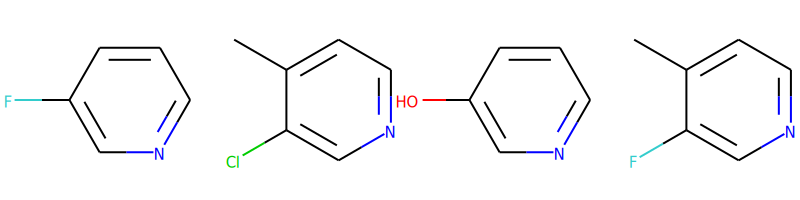

In [3]:
mols = [Chem.MolFromSmiles(smi) for smi in 'c1c(F)cccn1 c1c(Cl)c(C)ccn1 c1c(O)cccn1 c1c(F)c(C)ccn1'.split()]
Draw.MolsToGridImage(mols,molsPerRow=4)

In [4]:
scaffold = Chem.MolFromSmiles('c1ccccn1')

In [5]:
rgd = rdRGroupDecomposition.RGroupDecomposition(scaffold)
for m in mols:
    rgd.Add(m)
rgd.Process()

True

In [6]:
rgd.GetRGroupsAsColumns(asSmiles=True)

{'Core': ['c1cc([*:1])c([*:2])cn1',
  'c1cc([*:1])c([*:2])cn1',
  'c1cc([*:1])c([*:2])cn1',
  'c1cc([*:1])c([*:2])cn1'],
 'R1': ['[H][*:1]', '[H]C([H])([H])[*:1]', '[H][*:1]', '[H]C([H])([H])[*:1]'],
 'R2': ['F[*:2]', 'Cl[*:2]', '[H]O[*:2]', 'F[*:2]']}

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,

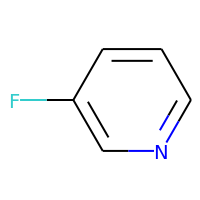
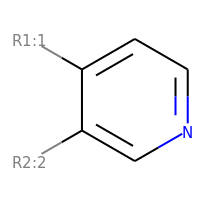
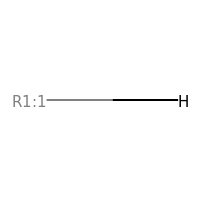
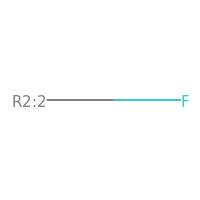
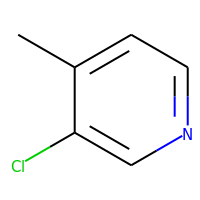
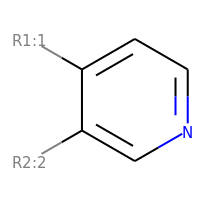
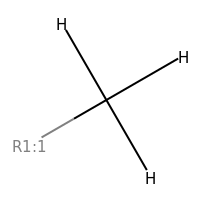
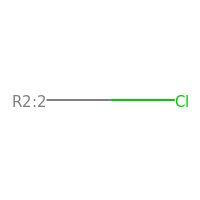
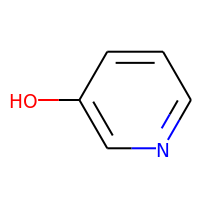
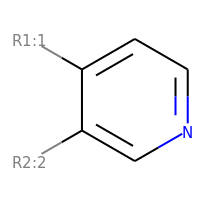
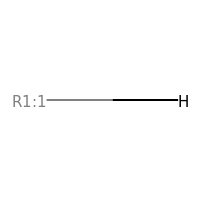
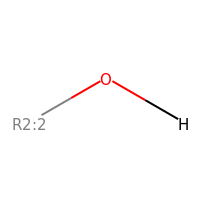
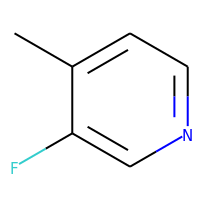
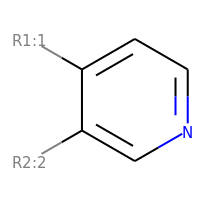
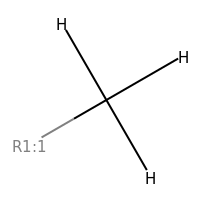
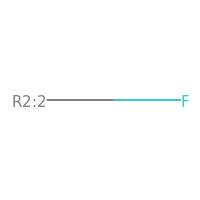

In [7]:
scaffold = Chem.MolFromSmiles('c1ccccn1')
rgd = rdRGroupDecomposition.RGroupDecomposition(scaffold)
for m in mols:
    rgd.Add(m)
rgd.Process()
groups = rgd.GetRGroupsAsColumns()
groups_to_df(groups,mols,include_core=True)

,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,

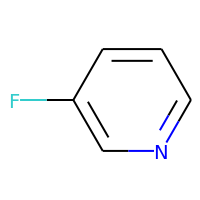
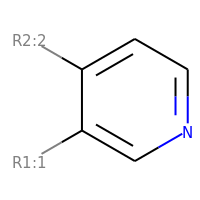
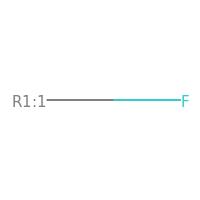
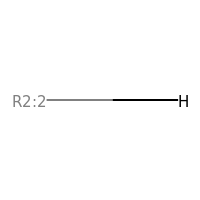
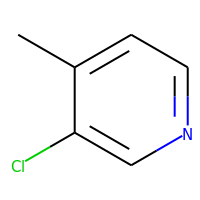
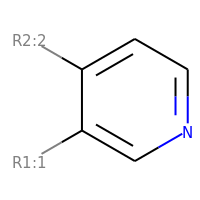
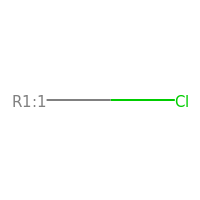
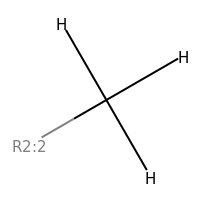
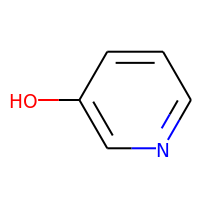
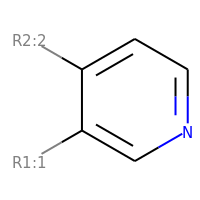
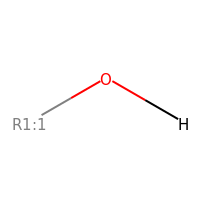
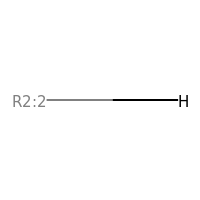
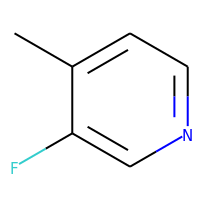
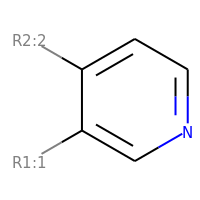
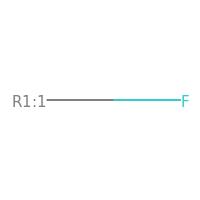
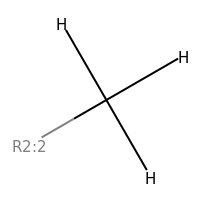

In [8]:
scaffold = Chem.MolFromSmiles('c1c([*:1])c([*:2])ccn1')
rgd = rdRGroupDecomposition.RGroupDecomposition(scaffold)
for m in mols:
    rgd.Add(m)
rgd.Process()
groups = rgd.GetRGroupsAsColumns()
groups_to_df(groups,mols,include_core=True)

In [9]:
print(rgd.GetRGroupsAsColumns(asSmiles=True))

{'Core': ['c1cc([*:2])c([*:1])cn1', 'c1cc([*:2])c([*:1])cn1', 'c1cc([*:2])c([*:1])cn1', 'c1cc([*:2])c([*:1])cn1'], 'R1': ['F[*:1]', 'Cl[*:1]', '[H]O[*:1]', 'F[*:1]'], 'R2': ['[H][*:2]', '[H]C([H])([H])[*:2]', '[H][*:2]', '[H]C([H])([H])[*:2]']}


What happens if there are small variations in the scaffold within the series, something that we see all the time in med chem work?

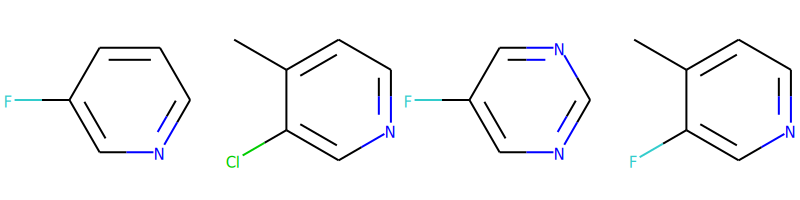

In [10]:
mols = [Chem.MolFromSmiles(smi) for smi in 'c1c(F)cccn1 c1c(Cl)c(C)ccn1 c1c(F)cncn1 c1c(F)c(C)ccn1'.split()]
Draw.MolsToGridImage(mols,molsPerRow=4)

In [11]:
scaffold = Chem.MolFromSmiles('c1c([*:1])c([*:2])ccn1')
rgd = rdRGroupDecomposition.RGroupDecomposition(scaffold)
for m in mols:
    rgd.Add(m)
rgd.Process()
groups = rgd.GetRGroupsAsColumns(asSmiles=True)
groups

{'Core': ['c1cc([*:2])c([*:1])cn1',
  'c1cc([*:2])c([*:1])cn1',
  'c1cc([*:2])c([*:1])cn1'],
 'R1': ['F[*:1]', 'Cl[*:1]', 'F[*:1]'],
 'R2': ['[H][*:2]', '[H]C([H])([H])[*:2]', '[H]C([H])([H])[*:2]']}

You can see that now we only get three results, the third molecule didn't end up in the output.
Sometimes this is ok, but in cases like this it would be great if that molecule were also included in the R-group decomposition. 

One solution to this is to provide two different scaffolds:

{'Core': ['c1cc([*:2])c([*:1])cn1', 'c1cc([*:2])c([*:1])cn1', 'c1ncc([*:1])c([*:2])n1', 'c1cc([*:2])c([*:1])cn1'], 'R1': ['F[*:1]', 'Cl[*:1]', 'F[*:1]', 'F[*:1]'], 'R2': ['[H][*:2]', '[H]C([H])([H])[*:2]', '[H][*:2]', '[H]C([H])([H])[*:2]']}


,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,

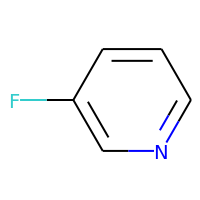
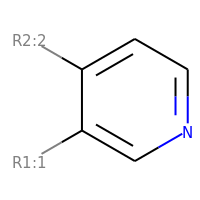
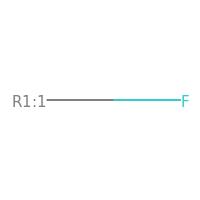
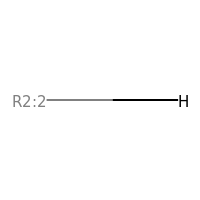
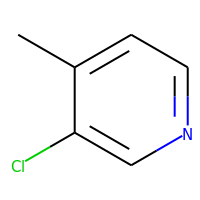
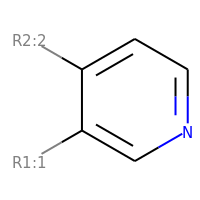
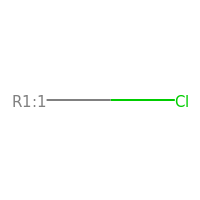
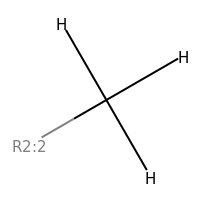
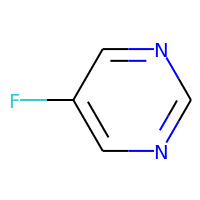
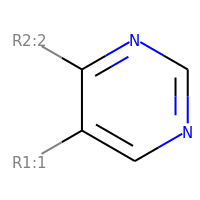
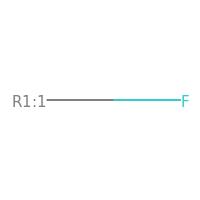
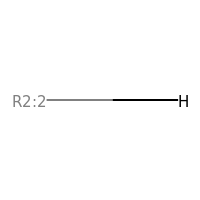
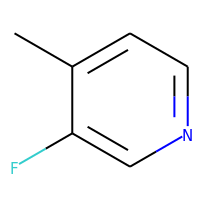
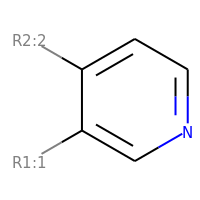
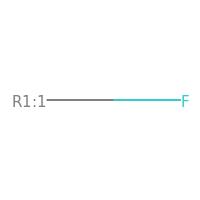
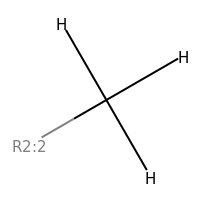

In [12]:
scaffold2 = Chem.MolFromSmiles('c1c([*:1])c([*:2])ncn1')
rgd = rdRGroupDecomposition.RGroupDecomposition([scaffold,scaffold2])
for m in mols:
    rgd.Add(m)
rgd.Process()
groups = rgd.GetRGroupsAsColumns()
print(rgd.GetRGroupsAsColumns(asSmiles=True))
groups_to_df(groups,mols,include_core=True)

Another is provide the scaffold as SMARTS and treat the variability point itself as one of the R groups:

{'Core': ['c1nc[*:3]c([*:2])c1[*:1]', 'c1nc[*:3]c([*:2])c1[*:1]', 'c1nc[*:3]c([*:2])c1[*:1]', 'c1nc[*:3]c([*:2])c1[*:1]'], 'R1': ['F[*:1]', 'Cl[*:1]', 'F[*:1]', 'F[*:1]'], 'R2': ['[H][*:2]', '[H]C([H])([H])[*:2]', '[H][*:2]', '[H]C([H])([H])[*:2]'], 'R3': ['[H]c(:[*:3]):[*:3]', '[H]c(:[*:3]):[*:3]', 'n(:[*:3]):[*:3]', '[H]c(:[*:3]):[*:3]']}


,Mol,Core,R1,R2,R3
0,,,,,
1,,,,,
2,,,,,
3,,,,,

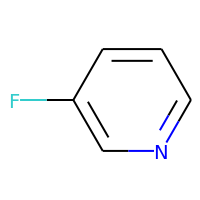
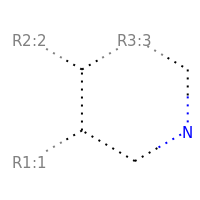
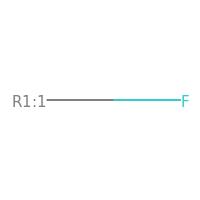
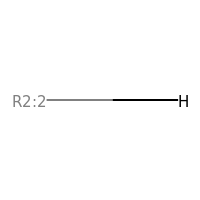
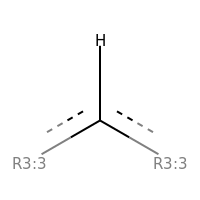
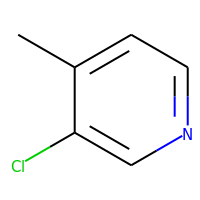
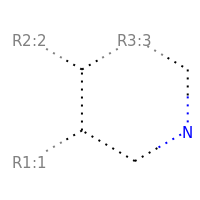
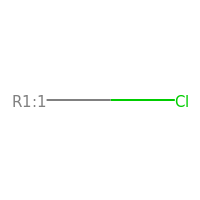
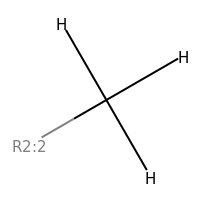
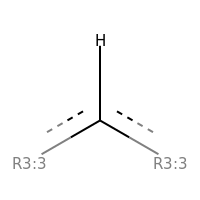
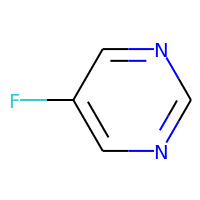
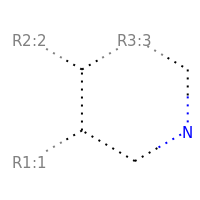
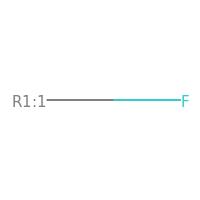
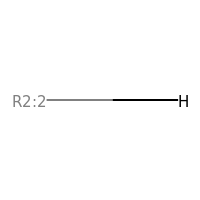
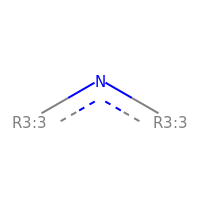
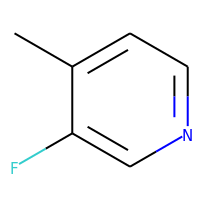
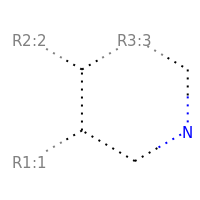
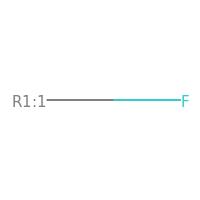
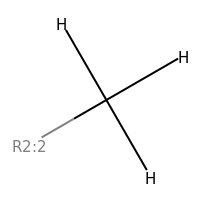
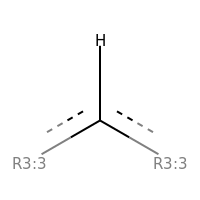

In [13]:
sma_scaffold = Chem.MolFromSmarts('c1c([*:1])c([*:2])*cn1')
rgd = rdRGroupDecomposition.RGroupDecomposition(sma_scaffold)
for m in mols:
    rgd.Add(m)
rgd.Process()
print(rgd.GetRGroupsAsColumns(asSmiles=True))
groups_to_df(rgd.GetRGroupsAsColumns(),mols,include_core=True)

In [42]:
params = rdRGroupDecomposition.RGroupDecompositionParameters()


In [ ]:
params.removeHydrogensPostMatch

In [59]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
def rgd_to_pandas(scaffolds,mols,redraw_mols=False,include_core=False):
    if not isinstance(scaffolds,list) and not isinstance(scaffolds,tuple):
        scaffolds = [scaffolds]
    params = rdRGroupDecomposition.RGroupDecompositionParameters()
    params.removeHydrogensPostMatch=True
    groups,unmatched = rdRGroupDecomposition.RGroupDecompose(scaffolds,mols,asRows=False,options=params)
    if redraw_mols:
        for k,vl in groups.items():
            if k=='Core':
                continue
            for v in (vl):
                rdDepictor.Compute2DCoords(v)
    
    matched_mols = [x for i,x in enumerate(mols) if i not in unmatched]
    cols = ['Mol']+list(groups.keys())
    if not include_core:
        cols.remove('Core')
        del groups['Core']
    groups['Mol'] = matched_mols
    for k,v in groups.items():
        print(k,len(v))
    frame = pd.DataFrame(groups,columns=cols)
    PandasTools.ChangeMoleculeRendering(frame)
    return frame


In [26]:
import pandas as pd
from rdkit.Chem import PandasTools

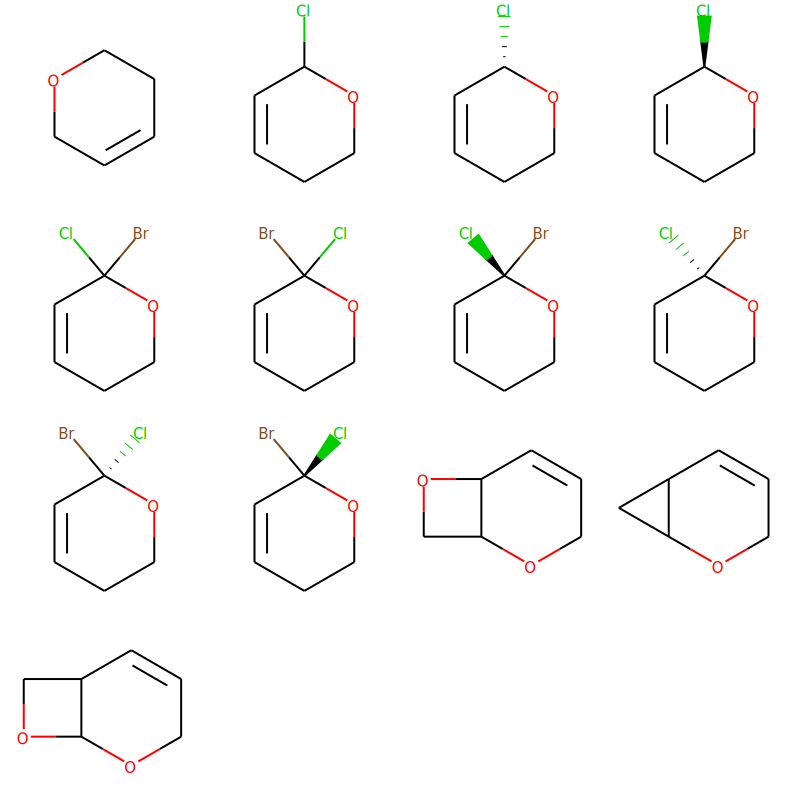

In [45]:
mols = [x for x in Chem.SDMolSupplier('../data/rgd_chiral.sdf')]
Draw.MolsToGridImage(mols,molsPerRow=4)

In [33]:
!cat ../data/rgd_chiral.sdf


  Mrv1824 02281916362D          

  6  6  0  0  1  0            999 V2000
    0.0000    0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145    0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7145   -0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7145    0.4125    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
  1  6  1  0  0  0  0
  2  3  1  0  0  0  0
  3  4  2  0  0  0  0
  4  5  1  0  0  0  0
  5  6  1  0  0  0  0
M  END
$$$$

  Mrv1824 02281916362D          

  7  7  0  0  1  0            999 V2000
    4.0291   -0.6482    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.3147   -1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.6002   -0.6482    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.6002    0.1768    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.

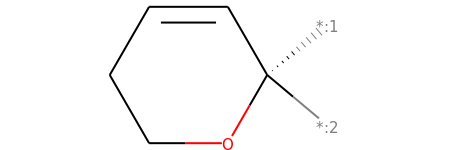

In [47]:
scaffold = Chem.MolFromSmiles('[*:1]C1([*:2])OCCC=C1')
chiral_scaffold = Chem.MolFromSmiles('[*:1][C@]1([*:2])OCCC=C1')
chiral_scaffold

,Mol,Core,R1,R2,R3,R4
0,,,,,,
1,,,,,,
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,
6,,,,,,
7,,,,,,
8,,,,,,
9,,,,,,

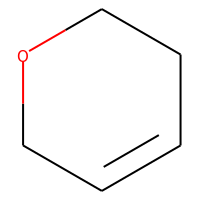
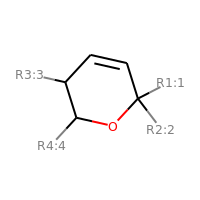
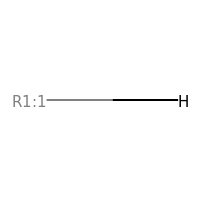
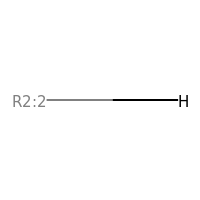
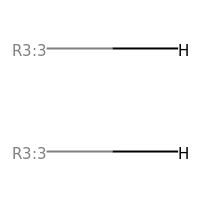
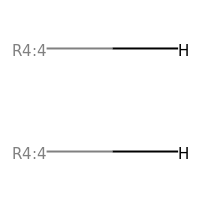
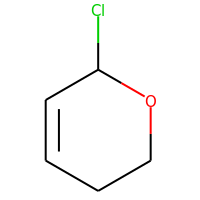
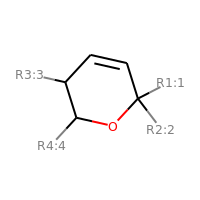
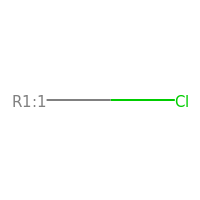
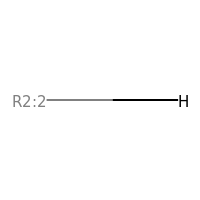
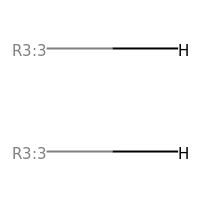
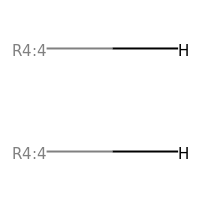
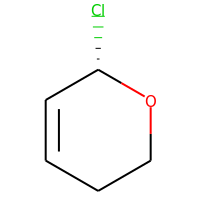
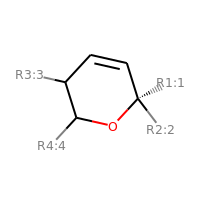
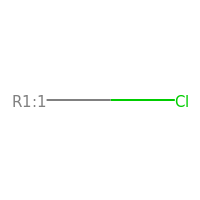
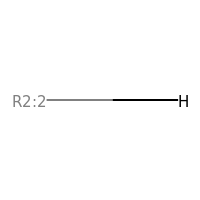
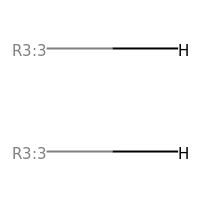
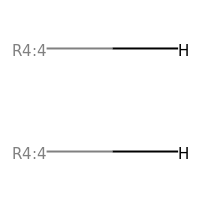
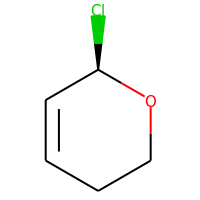
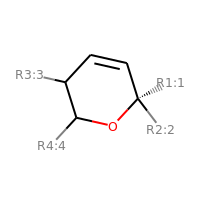
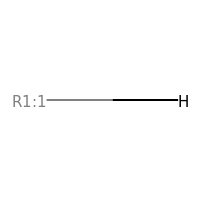
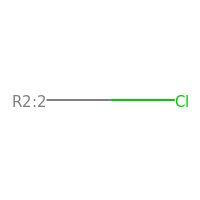
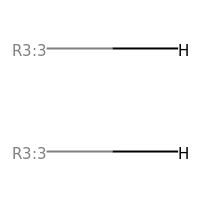
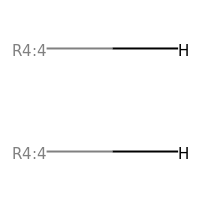
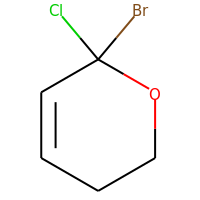
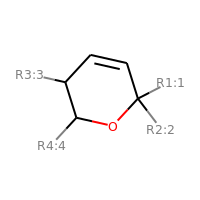
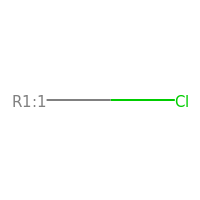
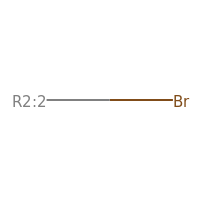
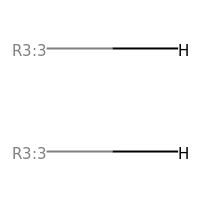
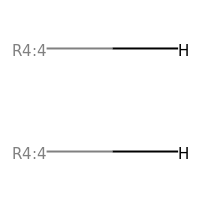
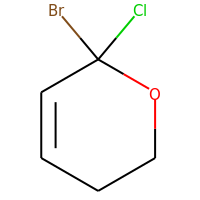
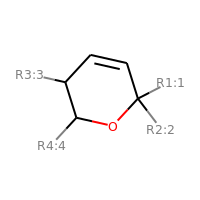
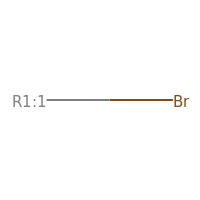
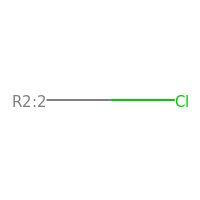
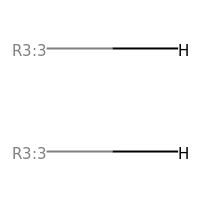
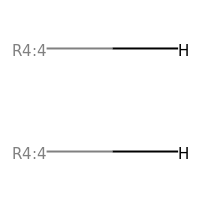
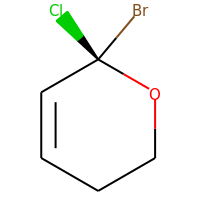
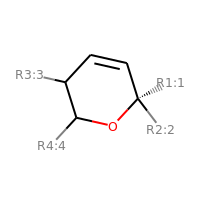
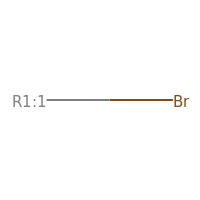
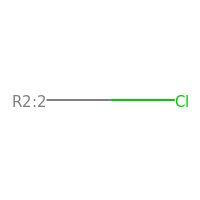
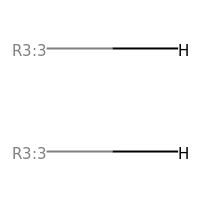
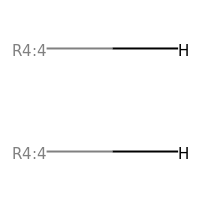
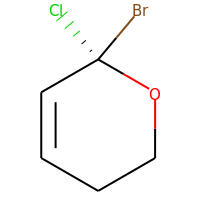
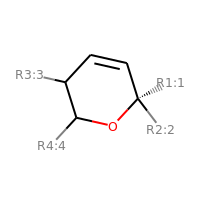
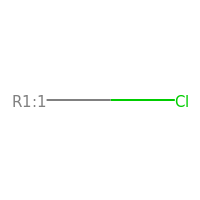
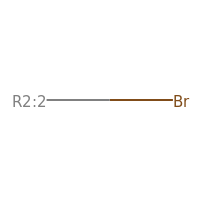
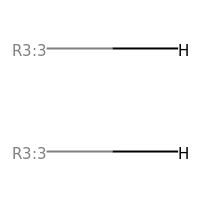
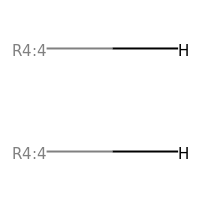
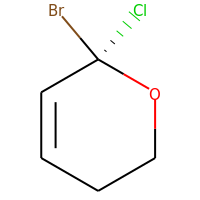
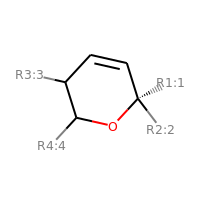
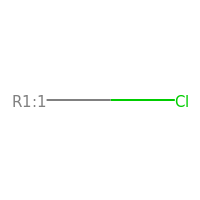
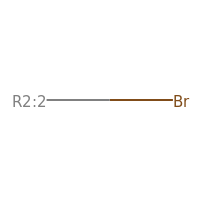
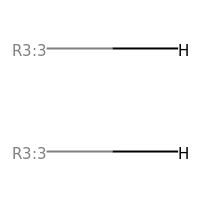
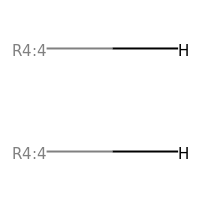
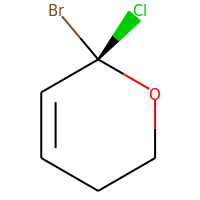
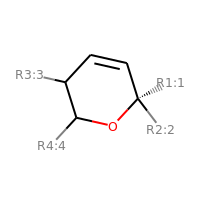
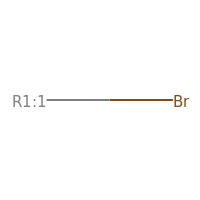
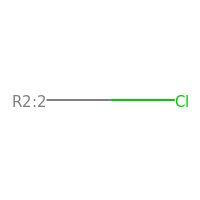
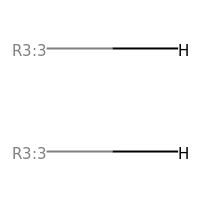
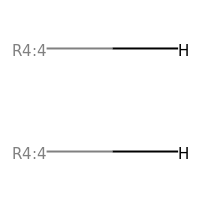
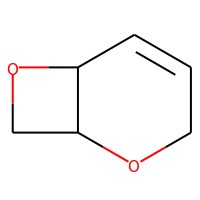
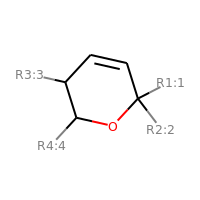
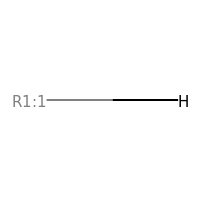
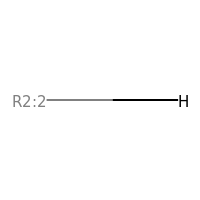
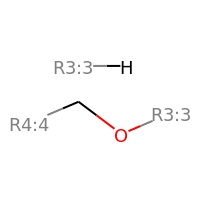
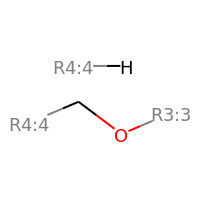
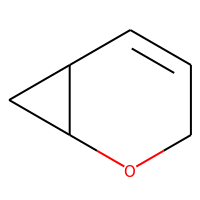
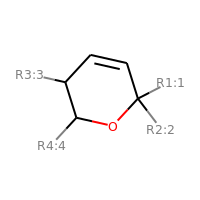
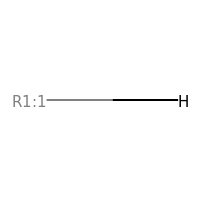
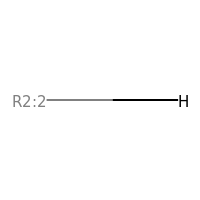
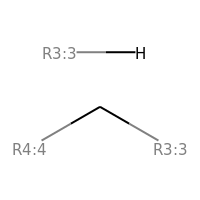
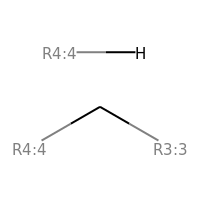
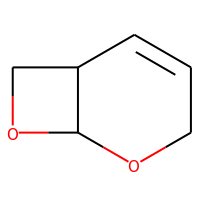
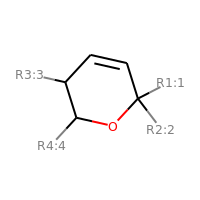
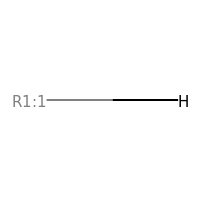
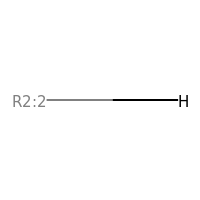
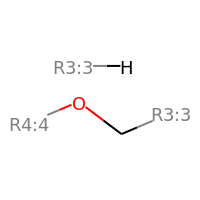
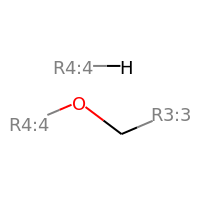

In [48]:
df = rgd_to_pandas([chiral_scaffold,scaffold],mols,redraw_mols=True,include_core=True)
df

In [30]:
rgd = rdRGroupDecomposition.RGroupDecomposition(scaffold)
nomatches = []
for i,m in enumerate(mols):
    if rgd.Add(m) < 0:
        nomatches.append(i)    
rgd.Process()
print(nomatches)

[]


In [31]:
chiral_rgd = rdRGroupDecomposition.RGroupDecomposition(chiral_scaffold)
chiral_nomatches = []
for i,m in enumerate(mols):
    if chiral_rgd.Add(m) < 0:
        chiral_nomatches.append(i)
chiral_rgd.Process()
print(chiral_nomatches)

[0, 1, 4, 5, 10, 11, 12]


,Mol,Core,R1,R2
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,
5,,,,

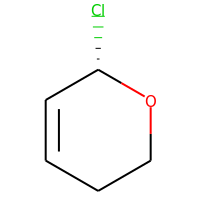
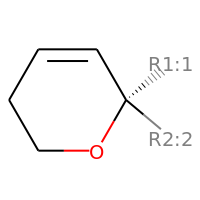
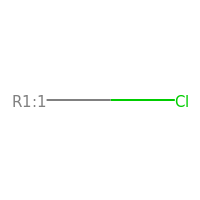
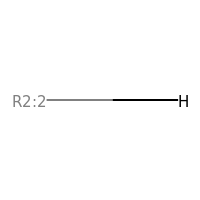
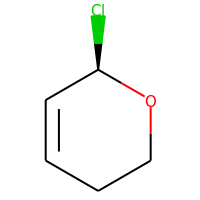
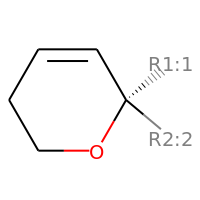
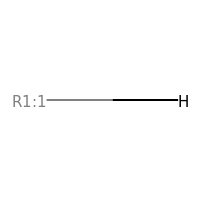
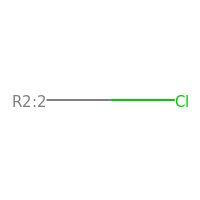
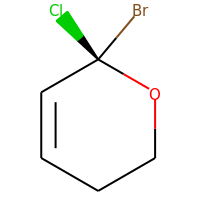
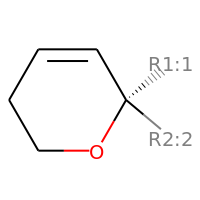
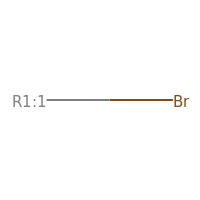
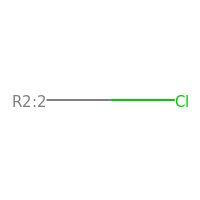
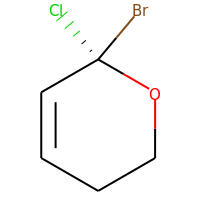
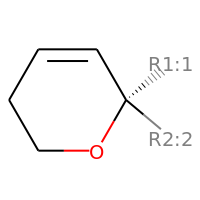
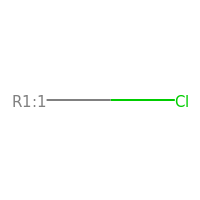
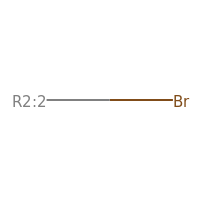
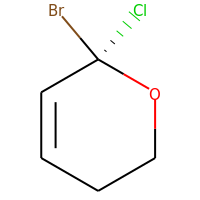
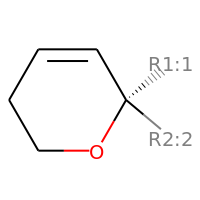
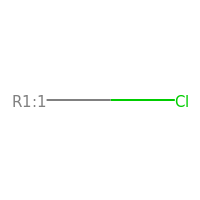
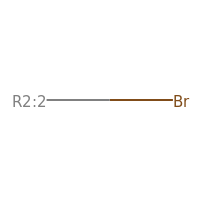
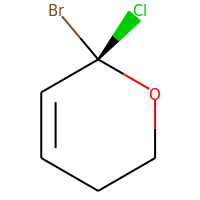
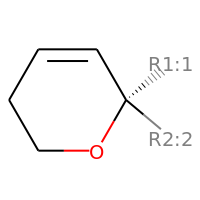
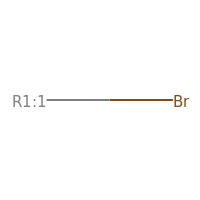
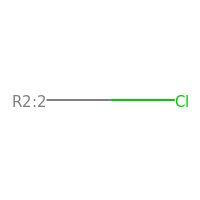

In [37]:
groups = chiral_rgd.GetRGroupsAsColumns()
for k,vl in groups.items():
    for v in vl:
        rdDepictor.Compute2DCoords(v)
groups_to_df(groups,[mols[i] for i in range(len(mols)) if i not in chiral_nomatches],include_core=True)

,Mol,Core,R1,R2,R3,R4
0,,,,,,
1,,,,,,
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,
6,,,,,,
7,,,,,,
8,,,,,,
9,,,,,,

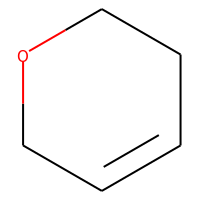
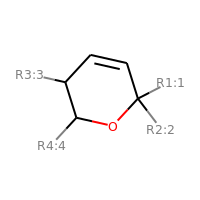
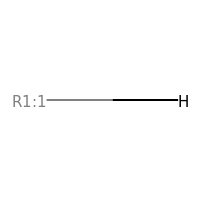
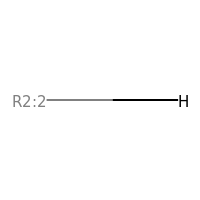
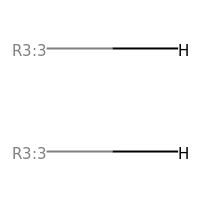
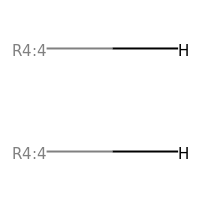
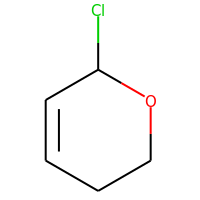
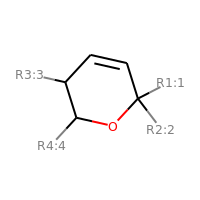
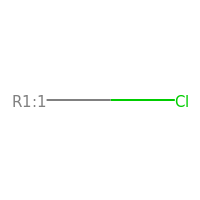
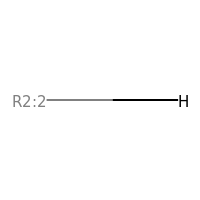
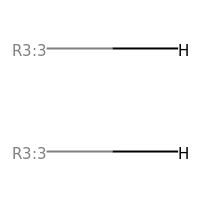
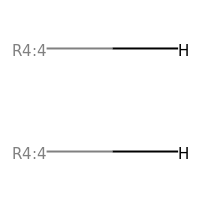
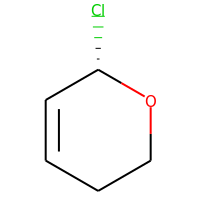
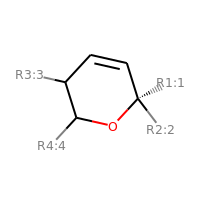
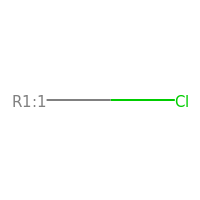
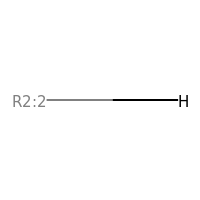
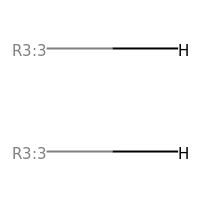
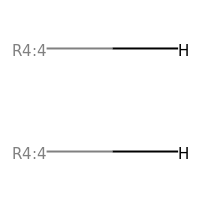
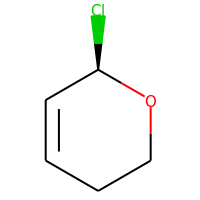
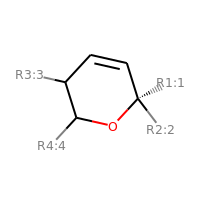
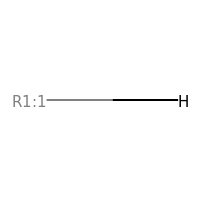
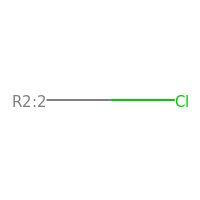
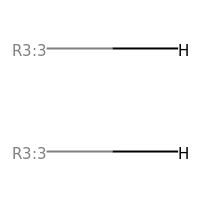
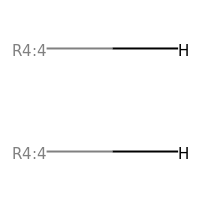
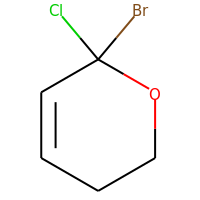
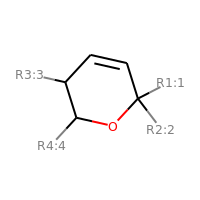
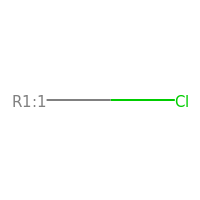
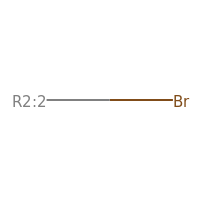
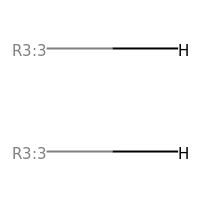
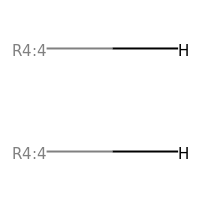
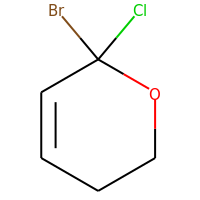
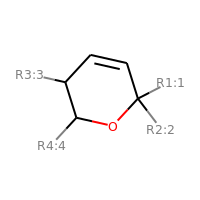
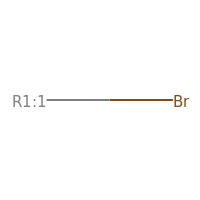
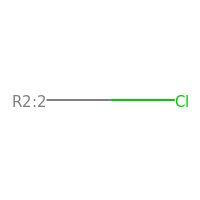
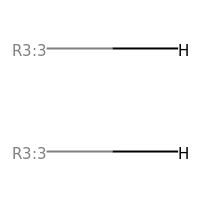
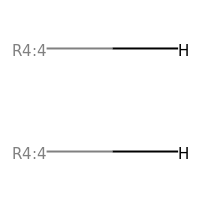
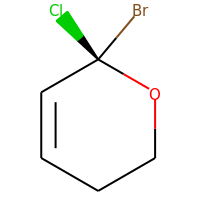
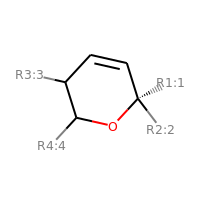
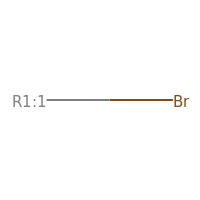
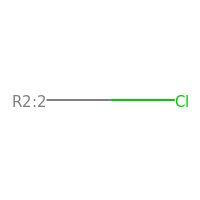
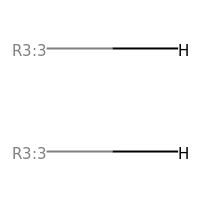
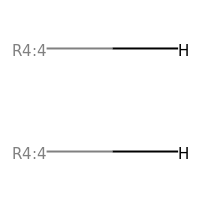
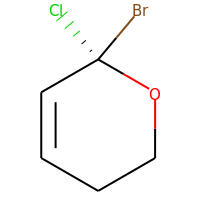
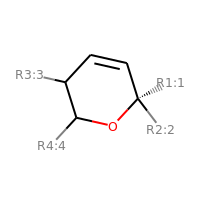
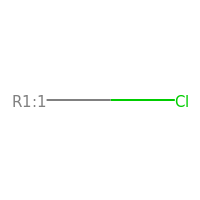
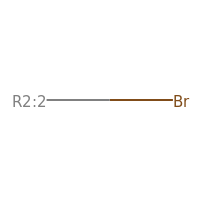
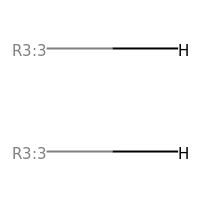
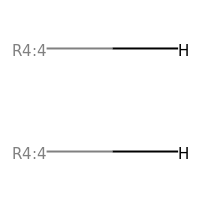
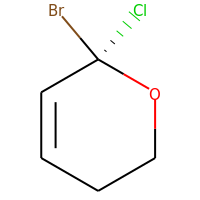
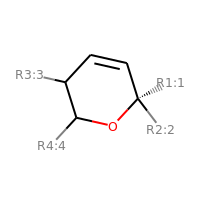
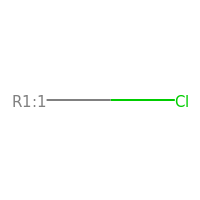
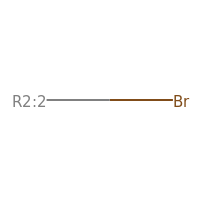
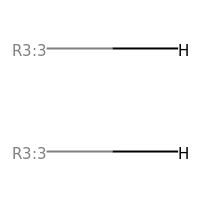
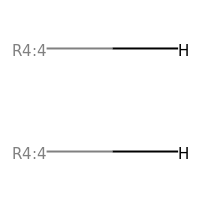
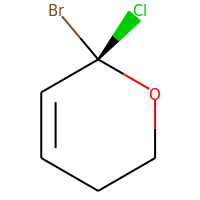
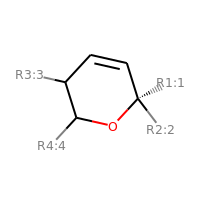
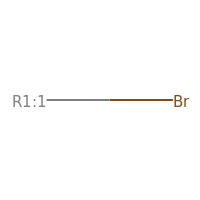
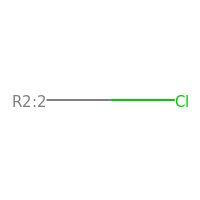
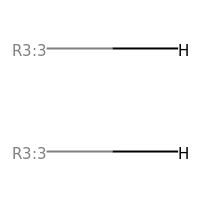
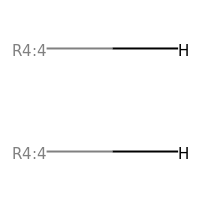
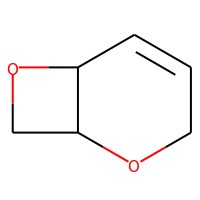
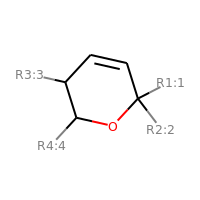
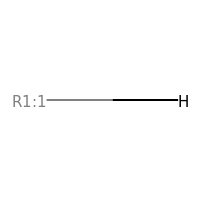
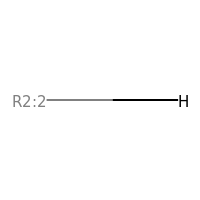
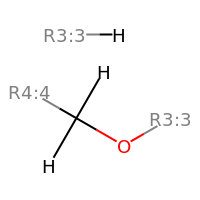
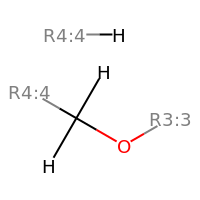
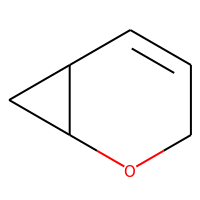
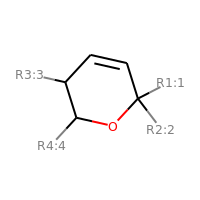
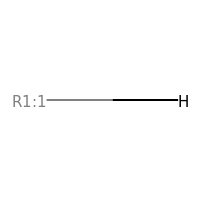
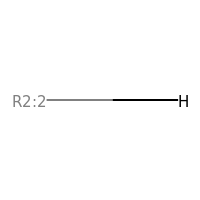
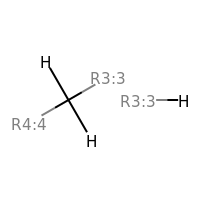
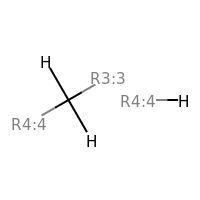
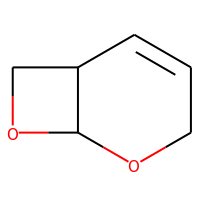
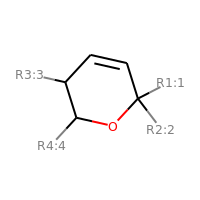
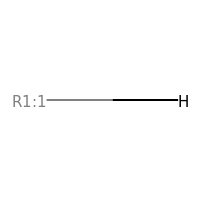
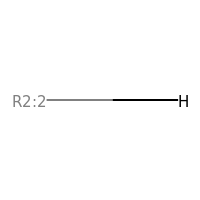
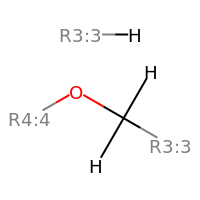
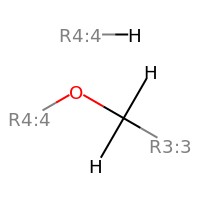

In [38]:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([chiral_scaffold,scaffold],mols,asRows=False)
for k,vl in groups.items():
    for v in vl:
        rdDepictor.Compute2DCoords(v)

groups_to_df(groups,[mols[i] for i in range(len(mols)) if i not in unmatched],include_core=True)


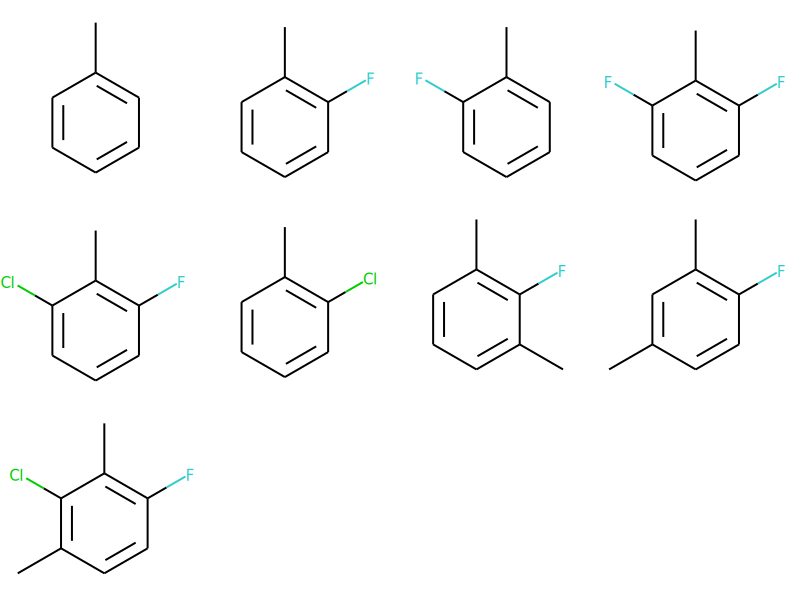

In [49]:
mols = [x for x in Chem.SDMolSupplier('../data/rgd_symm.sdf')]
Draw.MolsToGridImage(mols,molsPerRow=4)

,Mol,Core,R1,R2,R3,R4
0,,,,,,
1,,,,,,
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,
6,,,,,,
7,,,,,,
8,,,,,,

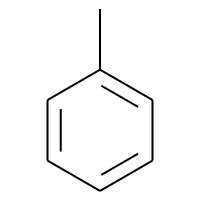
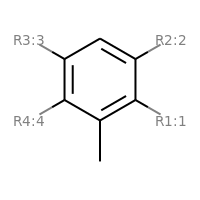
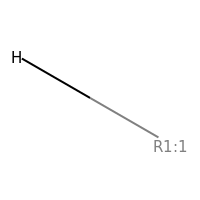
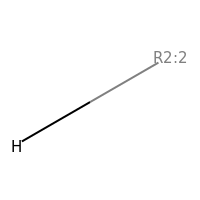
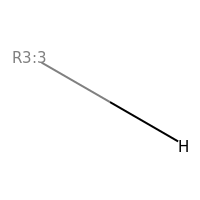
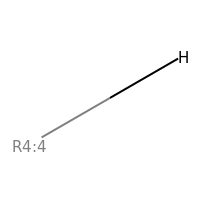
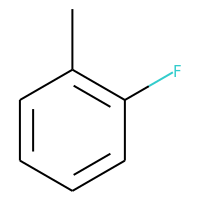
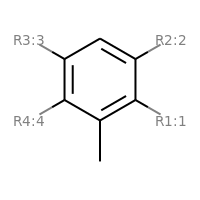
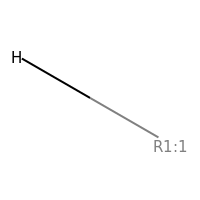
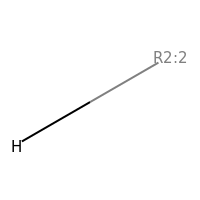
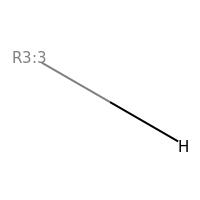
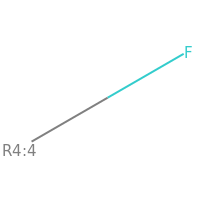
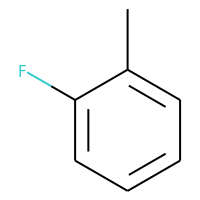
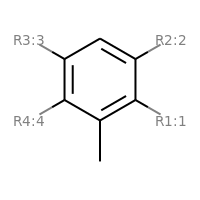
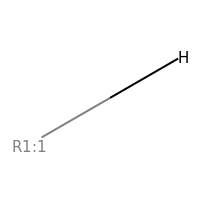
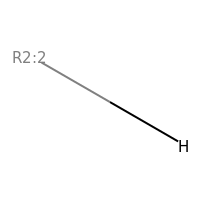
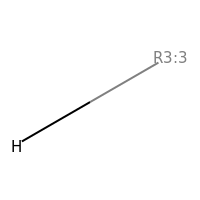
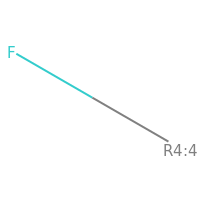
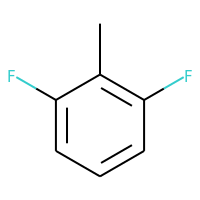
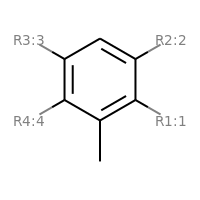
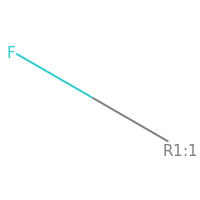
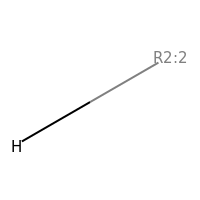
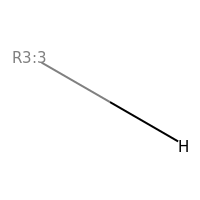
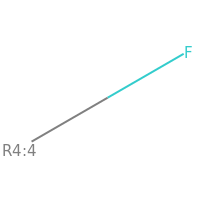
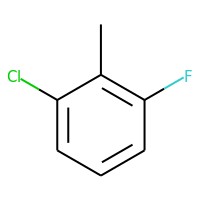
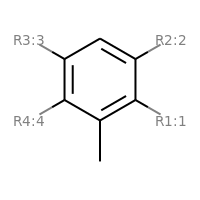
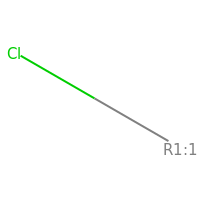
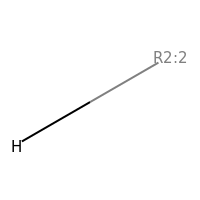
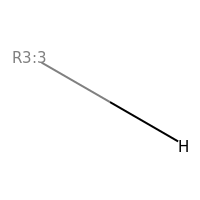
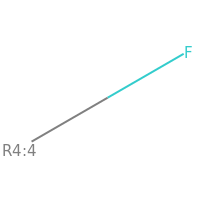
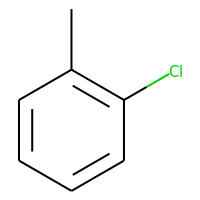
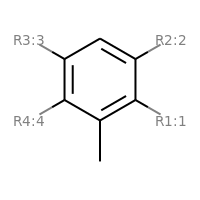
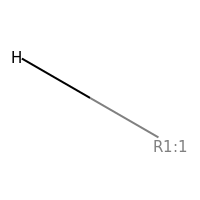
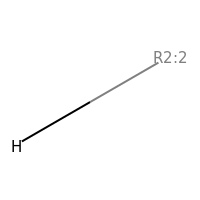
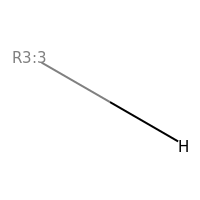
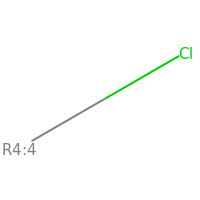
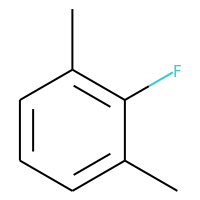
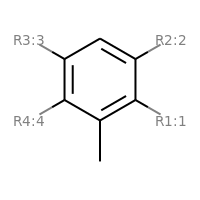
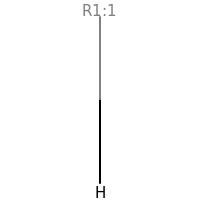
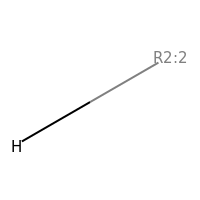
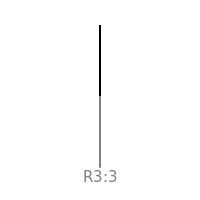
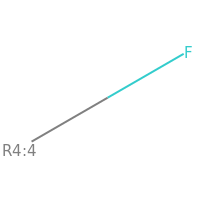
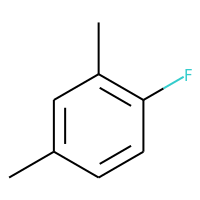
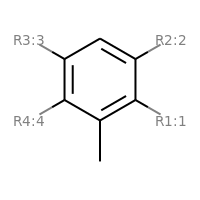
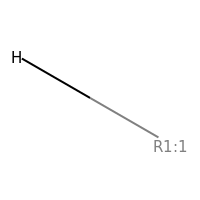
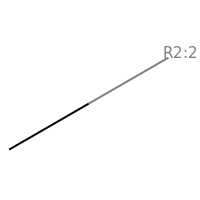
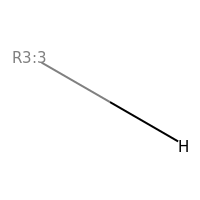
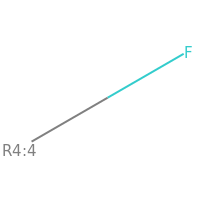
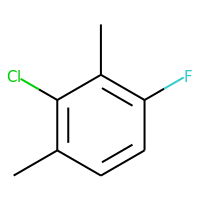
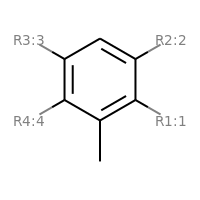
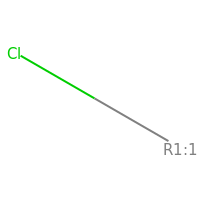
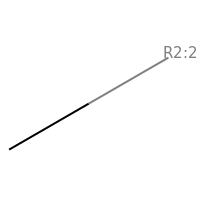
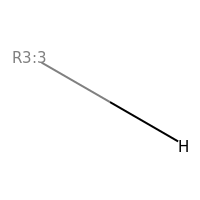
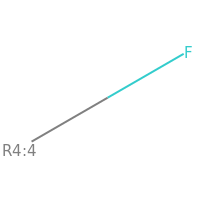

In [51]:
scaffold = Chem.MolFromSmiles('c1ccccc1C')

df = rgd_to_pandas(scaffold,mols,include_core=True)
df

,Mol,Core,R1,R2,R3
0,,,,,
1,,,,,
2,,,,,
3,,,,,

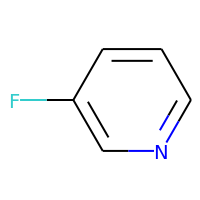
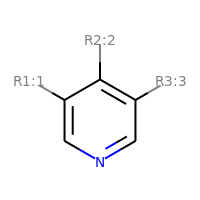
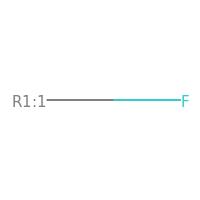
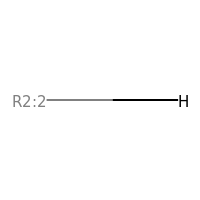
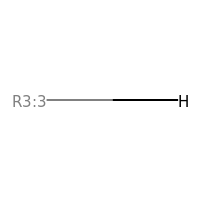
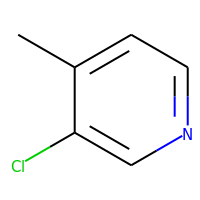
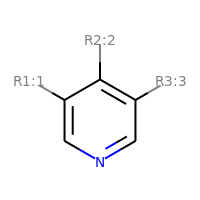
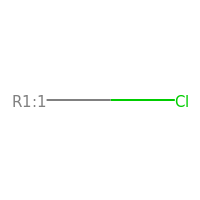
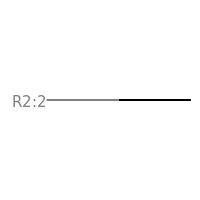
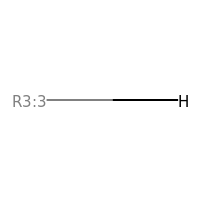
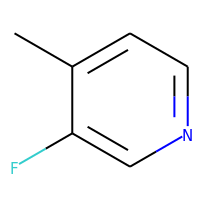
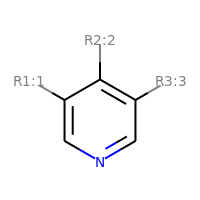
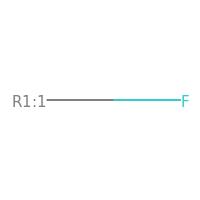
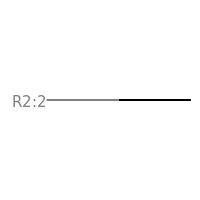
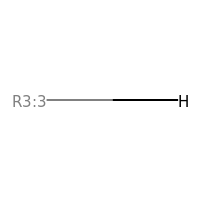
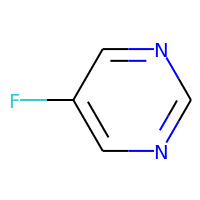
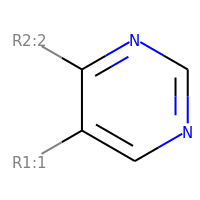
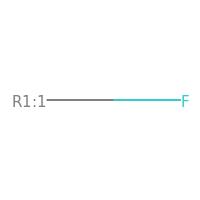
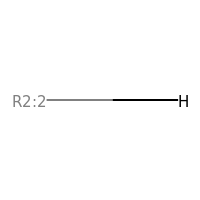
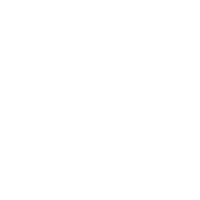

In [55]:
mols = [Chem.MolFromSmiles(smi) for smi in 'c1c(F)cccn1 c1c(Cl)c(C)ccn1 c1c(F)c(C)ccn1 c1c(F)cncn1'.split()]                                             
scaffold = Chem.MolFromSmiles('c1c([*:1])c([*:2])ccn1')                                                                                                  
scaffold2 = Chem.MolFromSmiles('c1c([*:1])c([*:2])ncn1')                                                                                                 
df = rgd_to_pandas([scaffold,scaffold2],mols,include_core=True)
df

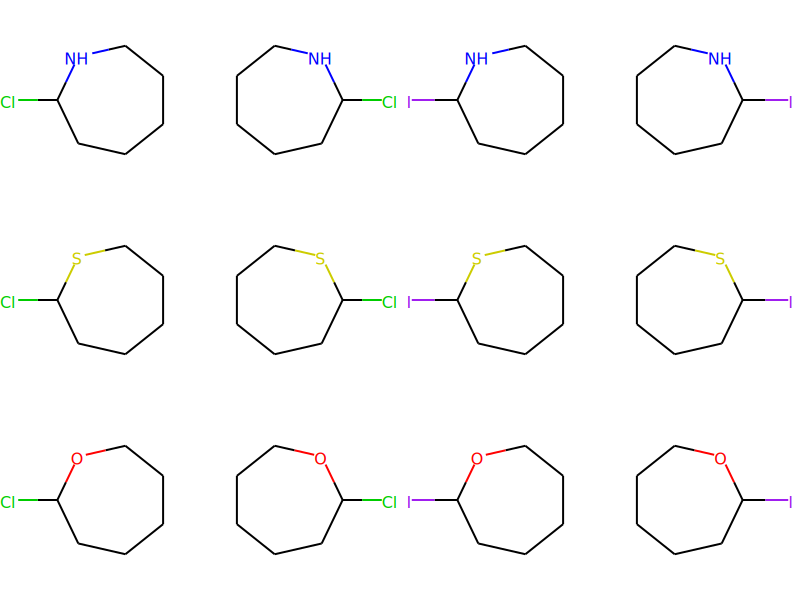

In [68]:
mols = [Chem.MolFromSmiles(smi) for smi in (
    "C1CCNC(Cl)CC1", "C1CC(Cl)NCCC1", "C1CCNC(I)CC1", "C1CC(I)NCCC1",
    "C1CCSC(Cl)CC1", "C1CC(Cl)SCCC1", "C1CCSC(I)CC1", "C1CC(I)SCCC1",
    "C1CCOC(Cl)CC1", "C1CC(Cl)OCCC1", "C1CCOC(I)CC1", "C1CC(I)OCCC1")]                                             
scaffolds = [Chem.MolFromSmarts(x) for x in ("C1CCNCCC1","C1CCOCCC1","C1CCSCCC1")]                                                                                                  
#df = rgd_to_pandas(scaffolds,mols,include_core=True)
Draw.MolsToGridImage(mols,molsPerRow=4)

In [64]:
params = rdRGroupDecomposition.RGroupDecompositionParameters()
params.removeHydrogensPostMatch=True
groups,unmatched = rdRGroupDecomposition.RGroupDecompose(scaffolds,mols,asRows=False,options=params)


In [65]:
groups

{'Core': [<rdkit.Chem.rdchem.Mol at 0x7fbba8626818>,
 'R1': [<rdkit.Chem.rdchem.Mol at 0x7fbba8626ce8>,
  <rdkit.Chem.rdchem.Mol at 0x7fbba8627240>]}

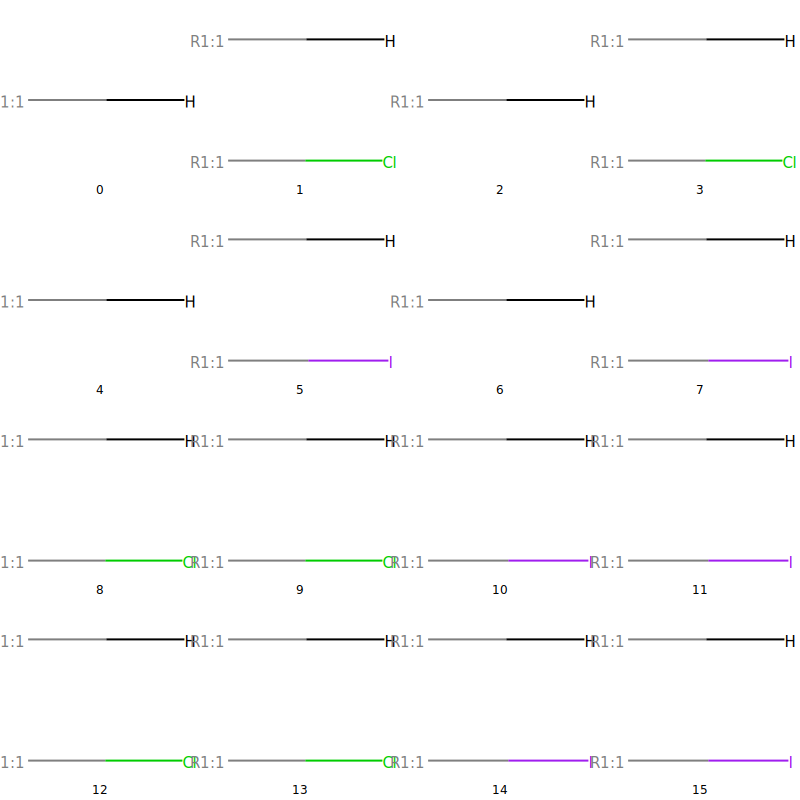

In [67]:
Draw.MolsToGridImage(groups['R1'],legends=[str(i) for i in range(len(groups['R1']))],molsPerRow=4)

In [70]:
mols = [Chem.MolFromSmiles(smi) for smi in (
    "C1CCNC(Cl)CC1", "C1CC(Cl)NCCC1", "C1CCNC(I)CC1", "C1CC(I)NCCC1",
    "C1CCSC(Cl)CC1", "C1CC(Cl)SCCC1", "C1CCSC(I)CC1", "C1CC(I)SCCC1",
    "C1CCOC(Cl)CC1", "C1CC(Cl)OCCC1", "C1CCOC(I)CC1", "C1CC(I)OCCC1")]                                             
scaffolds = [Chem.MolFromSmarts(x) for x in ("C1CCNCCC1","C1CCOCCC1","C1CCSCCC1")]                                                                                                  
groups,unmatched = rdRGroupDecomposition.RGroupDecompose(scaffolds,mols,asSmiles=True,asRows=False)
groups

{'Core': ['C1CCC([*:2])N([*:1])CC1',
  'C1CCC([*:2])N([*:1])CC1',
  'C1CCC([*:2])N([*:1])CC1',
  'C1CCC([*:2])N([*:1])CC1',
  'C1CCSC([*:1])CC1',
  'C1CCSC([*:1])CC1',
  'C1CCSC([*:1])CC1',
  'C1CCSC([*:1])CC1',
  'C1CCOC([*:1])CC1',
  'C1CCOC([*:1])CC1',
  'C1CCOC([*:1])CC1',
  'C1CCOC([*:1])CC1'],
 'R1': ['[H][*:1]',
  'Cl[*:1].[H][*:1]',
  '[H][*:1]',
  'Cl[*:1].[H][*:1]',
  '[H][*:1]',
  'I[*:1].[H][*:1]',
  '[H][*:1]',
  'I[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'I[*:1].[H][*:1]',
  'I[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'I[*:1].[H][*:1]',
  'I[*:1].[H][*:1]']}

In [73]:
mols = [Chem.MolFromSmiles(smi) for smi in (
    "C1CCNC(Cl)CC1", "C1CC(Cl)NCCC1","C1CC(I)NCCC1",
    "C1CCSC(Cl)CC1", 
    "C1CCOC(Cl)CC1", )]                                             
scaffolds = [Chem.MolFromSmarts(x) for x in ("C1CCNCCC1","C1CCOCCC1","C1CCSCCC1")]                                                                                                  
groups,unmatched = rdRGroupDecomposition.RGroupDecompose(scaffolds,mols,asSmiles=True,asRows=False)
groups

{'Core': ['C1CCC([*:1])N([*:2])CC1',
  'C1CCC([*:1])N([*:2])CC1',
  'C1CCC([*:1])N([*:2])CC1',
  'C1CCSC([*:1])CC1',
  'C1CCOC([*:1])CC1'],
 'R1': ['Cl[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'I[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]'],
 'R2': ['[H][*:2]', '[H][*:2]', '[H][*:2]', '', '']}

In [78]:
mols = [Chem.MolFromSmiles(smi) for smi in (
    "C1CCNC(Cl)CC1",  
    "C1CCOC(Cl)CC1", "C1CC(Cl)OCCC1", )]                                             
scaffolds = [Chem.MolFromSmarts(x) for x in ("C1CCNCCC1","C1CCOacCCC1","C1CCSCCC1")]                                                                                                  
groups,unmatched = rdRGroupDecomposition.RGroupDecompose(scaffolds,mols,asSmiles=True,asRows=False)
groups

{'Core': ['C1CCC([*:2])N([*:1])CC1', 'C1CCOC([*:1])CC1', 'C1CCOC([*:1])CC1'],
 'R1': ['[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]']}

In [82]:
mols = [Chem.MolFromSmiles(smi) for smi in (
    "C1NC(Cl)CC1",  
    "C1OC(Cl)CC1", "C1(Cl)OCCC1", )]                                             
scaffolds = [Chem.MolFromSmarts(x) for x in ("C1NCCC1","C1OCCC1")]                                                                                                  
groups,unmatched = rdRGroupDecomposition.RGroupDecompose(scaffolds,mols,asSmiles=True,asRows=True)
groups

[{'Core': 'C1CC([*:2])N([*:1])C1', 'R1': 'Cl[*:1].[H][*:1]'},
 {'Core': 'C1COC([*:1])C1', 'R1': 'Cl[*:1].[H][*:1]'},
 {'Core': 'C1COC([*:1])C1', 'R1': 'Cl[*:1].[H][*:1]'}]

In [83]:
mols = [Chem.MolFromSmiles(smi) for smi in (
    "C1NC(Cl)CC1",  
    "C1OC(Cl)CC1", "C1(Cl)OCCC1", )]                                             
scaffolds = [Chem.MolFromSmarts(x) for x in ("C1NCCC1","C1OCCC1")]                                                                                                  
groups,unmatched = rdRGroupDecomposition.RGroupDecompose(scaffolds,mols,asSmiles=True,asRows=False)
groups

{'Core': ['C1CC([*:2])N([*:1])C1', 'C1COC([*:1])C1', 'C1COC([*:1])C1'],
 'R1': ['[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]',
  'Cl[*:1].[H][*:1]']}